# Predicting Income using ABS Census Data

## Abstract

This project explores the use of machine learning models to predict income categories based on features of age, sex, industry of employment, health condition, education, and Indigenous status. The dataset was sourced from the ABS 2021 Census data. The dataset was preprocessed, analyzed, and modeled using four classification algorithms: Support Vector Machine (SVM), k-Nearest Neighbors (200NN), Random Forest, and Decision Tree. All models achieved similar accuracy levels of approximately 60%, with Random Forest and Decision Tree offering a balance between performance and efficiency. While SVM produced comparable results, it required significant computational time and a reduced dataset size. These findings highlight the trade-offs between model complexity, performance, and scalability in income classification tasks.

## Introduction

This project aims to predict income levels using data from the 2021 Australian Census, sourced from the Australian Bureau of Statistics. The data generated using the [TableBuilder](https://www.abs.gov.au/statistics/microdata-tablebuilder/tablebuilder) tool, selecting key demographic and socioeconomic variables: age, sex, industry of employment, highest level of educational attainment, Indigenous status, and health conditions. These features were chosen to assess their predictive power for income classification. The resulting dataset has been included in the accompanying GitHub repository.

In [2]:
import pandas as pd

import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt

import scipy.stats as stats

## Data Cleaning

The initial dataset was not in a format suitable for data analysis or machine learning, as it included unnecessary headings and was structured as a cross-tabulation. Each row represented a unique combination of attributes — age, sex, industry, health condition, education, and Indigenous status — while each column indicated the number of individuals falling within a specific income range.

In [3]:
df = pd.read_csv("income_data.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291841 entries, 0 to 291840
Data columns (total 24 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   Unnamed: 0                           21 non-null      object 
 1   Unnamed: 1                           41 non-null      object 
 2   Unnamed: 2                           161 non-null     object 
 3   Unnamed: 3                           1281 non-null    object 
 4   Unnamed: 4                           24321 non-null   object 
 5   INCP Total Personal Income (weekly)  291841 non-null  object 
 6   Negative income                      291840 non-null  float64
 7   Nil income                           291840 non-null  float64
 8   $1-$149 ($1-$7,799)                  291840 non-null  float64
 9   $150-$299 ($7,800-$15,599)           291840 non-null  float64
 10  $300-$399 ($15,600-$20,799)          291840 non-null  float64
 11  $400-$499 ($2

In [3]:
df.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,INCP Total Personal Income (weekly),Negative income,Nil income,"$1-$149 ($1-$7,799)","$150-$299 ($7,800-$15,599)",...,"$800-$999 ($41,600-$51,999)","$1,000-$1,249 ($52,000-$64,999)","$1,250-$1,499 ($65,000-$77,999)","$1,500-$1,749 ($78,000-$90,999)","$1,750-$1,999 ($91,000-$103,999)","$2,000-$2,999 ($104,000-$155,999)","$3,000-$3,499 ($156,000-$181,999)","$3,500 or more ($182,000 or more)",Total,Unnamed: 23
0,AGE5P Age in Five Year Groups,SEXP Sex,INGP Indigenous Status,1-digit level HEAP Level of Highest Educationa...,1-digit level INDP Industry of Employment,LTHP Type of Long-term Health Condition,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Arthritis,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
2,NaN,NaN,NaN,NaN,NaN,Asthma,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,NaN,NaN,NaN,NaN,NaN,Cancer (including remission),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,NaN,NaN,NaN,NaN,NaN,Dementia (including Alzheimer's),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


The below code will remove all headings in the original dataset as they were spread across multiple rows and made it difficult to interpret the variables. Additionally, a "Total" column, which does not contribute useful information for analysis or modeling, is also removed.

In [4]:
age_to_income = df.iloc[1:, list(range(0, 22))].values.tolist()

income_data = pd.DataFrame(
    age_to_income,
    columns=[
        "age", 
        "sex", 
        "indigenous_status", 
        "education", 
        "industry", 
        "health_conditions", 
        "negative_income",
        "nil_income",
        "$1-$7799",
        "$7,800-$15,599",
        "$15,600-$20,799",
        "$20,800-$25,999",
        "$26,000-$33,799",
        "$33,800-$41,599",
        "$41,600-$51,999",
        "$52,000-$64,999",
        "$65,000-$77,999",
        "$78,000-$90,999",
        "$91,000-$103,999",
        "$104,000-$155,999",
        "$156,000-$181,999",
        "$182,000 or more"
    ]

)

income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291840 entries, 0 to 291839
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   age                20 non-null      object 
 1   sex                40 non-null      object 
 2   indigenous_status  160 non-null     object 
 3   education          1280 non-null    object 
 4   industry           24320 non-null   object 
 5   health_conditions  291840 non-null  object 
 6   negative_income    291840 non-null  float64
 7   nil_income         291840 non-null  float64
 8   $1-$7799           291840 non-null  float64
 9   $7,800-$15,599     291840 non-null  float64
 10  $15,600-$20,799    291840 non-null  float64
 11  $20,800-$25,999    291840 non-null  float64
 12  $26,000-$33,799    291840 non-null  float64
 13  $33,800-$41,599    291840 non-null  float64
 14  $41,600-$51,999    291840 non-null  float64
 15  $52,000-$64,999    291840 non-null  float64
 16  $6

Next, the dataset contains a row in the age column labeled as a total, followed by rows representing aggregated totals for combinations of variables. These rows are not useful for analysis and will be removed to ensure only individual-level combinations are retained.

In [5]:
total_index = income_data[income_data['age'].str.lower() == 'total'].index

if not total_index.empty:
    income_data = income_data.iloc[:total_index[0]]

income_data.head()

,age,sex,indigenous_status,education,industry,health_conditions,negative_income,nil_income,$1-$7799,"$7,800-$15,599",...,"$26,000-$33,799","$33,800-$41,599","$41,600-$51,999","$52,000-$64,999","$65,000-$77,999","$78,000-$90,999","$91,000-$103,999","$104,000-$155,999","$156,000-$181,999","$182,000 or more"
0,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Arthritis,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,NaN,NaN,NaN,NaN,NaN,Asthma,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,NaN,NaN,NaN,NaN,NaN,Cancer (including remission),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,NaN,NaN,NaN,NaN,Dementia (including Alzheimer's),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,Diabetes (excluding gestational diabetes),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Rows containing NaN values need to be addressed, as they appear in the original dataset where certain fields are only listed once and assumed to apply to subsequent rows. To preserve this structure, a forward fill method is applied, which propagates the last valid observation forward to fill in the missing values.

In [6]:
income_data = income_data.ffill()

income_data.head()

,age,sex,indigenous_status,education,industry,health_conditions,negative_income,nil_income,$1-$7799,"$7,800-$15,599",...,"$26,000-$33,799","$33,800-$41,599","$41,600-$51,999","$52,000-$64,999","$65,000-$77,999","$78,000-$90,999","$91,000-$103,999","$104,000-$155,999","$156,000-$181,999","$182,000 or more"
0,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Arthritis,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Asthma,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Cancer (including remission),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Dementia (including Alzheimer's),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Diabetes (excluding gestational diabetes),0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To prepare the dataset for data analysis and machine learning, the income brackets which were originally represented as separate columns, will be consolidated into a single column named `income_bracket`. A corresponding count column will be created to represent the number of individuals for each unique combination of variables and income bracket. This transformation will be performed using `pd.melt()`, which reshapes the dataset from wide format to long format.

In [7]:
income_melted = pd.melt(income_data, id_vars=[
        "age", 
        "sex", 
        "indigenous_status", 
        "education", 
        "industry", 
        "health_conditions"
    ], 
    value_vars=[
        "negative_income",
        "nil_income",
        "$1-$7799",
        "$7,800-$15,599",
        "$15,600-$20,799",
        "$20,800-$25,999",
        "$26,000-$33,799",
        "$33,800-$41,599",
        "$41,600-$51,999",
        "$52,000-$64,999",
        "$65,000-$77,999",
        "$78,000-$90,999",
        "$91,000-$103,999",
        "$104,000-$155,999",
        "$156,000-$181,999",
        "$182,000 or more"
    ], 
    var_name='income_bracket', 
    value_name='count'
)

income_melted.head()

,age,sex,indigenous_status,education,industry,health_conditions,income_bracket,count
0,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Arthritis,negative_income,0.0
1,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Asthma,negative_income,0.0
2,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Cancer (including remission),negative_income,0.0
3,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Dementia (including Alzheimer's),negative_income,0.0
4,10-14 years,Male,Non-Indigenous,Postgraduate Degree Level,"Agriculture, Forestry and Fishing",Diabetes (excluding gestational diabetes),negative_income,0.0


Additionally, the `count` column will be removed, and each row will be duplicated according to its count value. This transformation ensures that each row in the dataset represents a single individual, allowing the data to align with the typical structure required for machine learning models, where each row corresponds to one observation.

In [8]:
income_repeated = income_melted.loc[income_melted.index.repeat(income_melted['count'])].reset_index(drop=True).drop("count", axis=1)
income_repeated.head()

,age,sex,indigenous_status,education,industry,health_conditions,income_bracket
0,15-19 years,Male,Non-Indigenous,Certificate III & IV Level,"Agriculture, Forestry and Fishing",No long-term health condition(s),negative_income
1,15-19 years,Male,Non-Indigenous,Certificate III & IV Level,"Agriculture, Forestry and Fishing",No long-term health condition(s),negative_income
2,15-19 years,Male,Non-Indigenous,Certificate III & IV Level,"Agriculture, Forestry and Fishing",No long-term health condition(s),negative_income
3,15-19 years,Male,Non-Indigenous,Certificate III & IV Level,"Agriculture, Forestry and Fishing",No long-term health condition(s),negative_income
4,15-19 years,Male,Non-Indigenous,Certificate III & IV Level,"Agriculture, Forestry and Fishing",No long-term health condition(s),negative_income


The bar plot below illustrates that the original dataset includes a large number of income brackets, which can hinder the performance of machine learning models due to class imbalance and increased complexity. Hence, all income brackets will be consolidated into three broader brackets: `$1-41,599`, `$41,600-90,999`, and `$91,000-more`. Those with negative or nil income make up a tiny proportion of the overall population in the dataset. Hence, rows with negative or nil income will be removed from the dataset, as their low frequency makes it difficult for models to learn meaningful patterns for those cases.

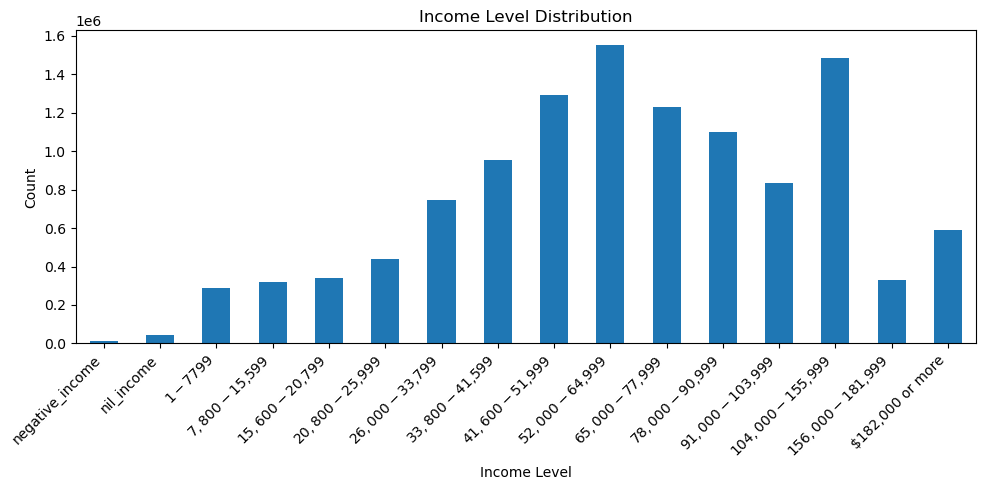

In [9]:
income_counts = income_repeated['income_bracket'].value_counts()
income_counts = income_counts.reindex([
    "negative_income",
    "nil_income",
    "$1-$7799",
    "$7,800-$15,599",
    "$15,600-$20,799",
    "$20,800-$25,999",
    "$26,000-$33,799",
    "$33,800-$41,599",
    "$41,600-$51,999",
    "$52,000-$64,999",
    "$65,000-$77,999",
    "$78,000-$90,999",
    "$91,000-$103,999",
    "$104,000-$155,999",
    "$156,000-$181,999",
    "$182,000 or more"
])

income_counts.plot(kind='bar', figsize=(10,5))
plt.title("Income Level Distribution")
plt.xlabel("Income Level")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [10]:
lower_income = [
    "$1-$7799",
    "$7,800-$15,599",
    "$15,600-$20,799",
    "$20,800-$25,999",
    "$26,000-$33,799",
    "$33,800-$41,599"
]
middle_income = [
    "$41,600-$51,999",
    "$52,000-$64,999",
    "$65,000-$77,999",
    "$78,000-$90,999"
]
high_income = [
    "$91,000-$103,999",
    "$104,000-$155,999",
    "$156,000-$181,999",
    "$182,000 or more"
]

income_repeated.loc[income_repeated["income_bracket"].isin(lower_income), "income_bracket"] = "$1-41,599"
income_repeated.loc[income_repeated["income_bracket"].isin(middle_income), "income_bracket"] = "$41,600-90,999"
income_repeated.loc[income_repeated["income_bracket"].isin(high_income), "income_bracket"] = "$91,000-more"

income_repeated = income_repeated.loc[~income_repeated["income_bracket"].isin(["negative_income", "nil_income"])]

income_repeated

,age,sex,indigenous_status,education,industry,health_conditions,income_bracket
55994,15-19 years,Male,Non-Indigenous,Bachelor Degree Level,Retail Trade,No long-term health condition(s),"$1-41,599"
55995,15-19 years,Male,Non-Indigenous,Bachelor Degree Level,Retail Trade,No long-term health condition(s),"$1-41,599"
55996,15-19 years,Male,Non-Indigenous,Bachelor Degree Level,Retail Trade,No long-term health condition(s),"$1-41,599"
55997,15-19 years,Male,Non-Indigenous,Bachelor Degree Level,Retail Trade,No long-term health condition(s),"$1-41,599"
55998,15-19 years,Male,Non-Indigenous,Bachelor Degree Level,Retail Trade,No long-term health condition(s),"$1-41,599"
...,...,...,...,...,...,...,...
11557570,90-94 years,Female,Non-Indigenous,Secondary Education - Years 10 and above,Financial and Insurance Services,Any other long-term health condition(s),"$91,000-more"
11557571,90-94 years,Female,Non-Indigenous,Secondary Education - Years 10 and above,Financial and Insurance Services,Any other long-term health condition(s),"$91,000-more"
11557572,95-99 years,Female,Non-Indigenous,Bachelor Degree Level,"Rental, Hiring and Real Estate Services",Arthritis,"$91,000-more"
11557573,95-99 years,Female,Non-Indigenous,Bachelor Degree Level,"Rental, Hiring and Real Estate Services",Arthritis,"$91,000-more"


## Exploratory Data Analaysis

In the new income bracket distribution, the lower and higher brackets contain a similar number of individuals, while the middle income bracket has a noticeably larger population. This new distribution is much more balanced than before.

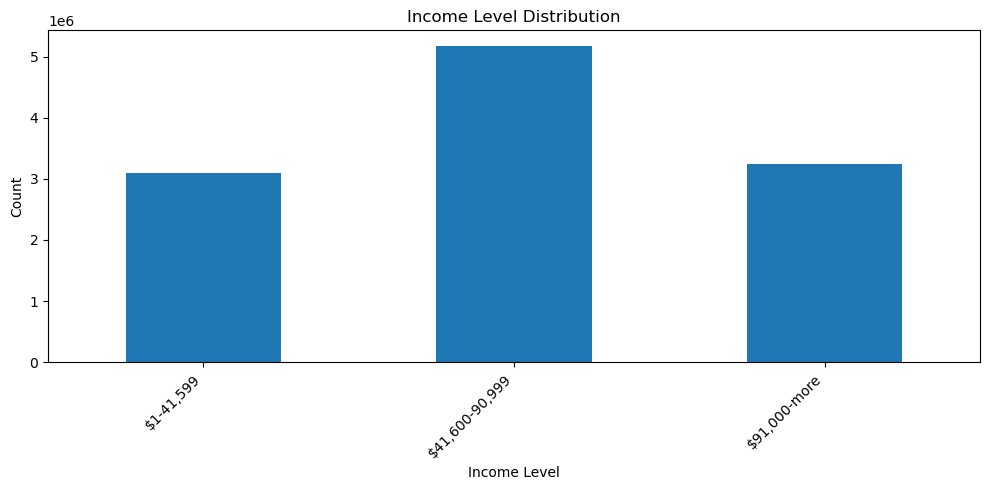

In [11]:
income_counts = income_repeated['income_bracket'].value_counts()
income_counts = income_counts.reindex(["$1-41,599", "$41,600-90,999", "$91,000-more"])

income_counts.plot(kind='bar', figsize=(10,5))
plt.title("Income Level Distribution")
plt.xlabel("Income Level")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

The barplot of income distribution by sex suggests that in the middle income bracket there is little differentiating the number of males and females in the middle income bracket. However, there are significantly more males than females who earn higher incomes in the higher income bracket, while there are significantly more females who earn lower incomes than males in the lower income bracket. This suggests that it may be difficult to use sex to predict income levels because a gender imbalance only occurs at both extremes of the income spectrum. Additional factors for predicting income will need to be considered.

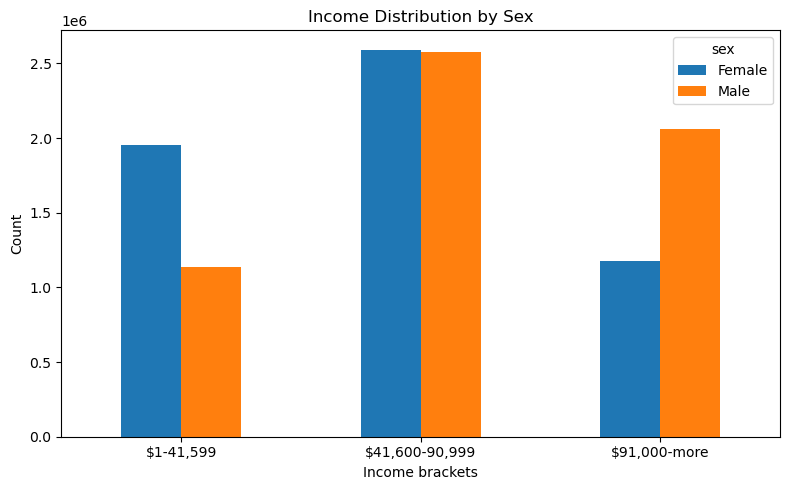

In [12]:
sex_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["sex"]) 

sex_income.plot(kind='bar', figsize=(8, 5))
plt.title("Income Distribution by Sex")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar plot of income distribution by Indigenous status reveals that Indigenous Australians make up a smaller share of income earners across all income brackets compared to non-Indigenous Australians. This reflects their smaller proportion in the overall population. However, when examining the distribution within each group, a clearer pattern emerges: while both Indigenous and non-Indigenous Australians are most commonly found in the middle income bracket, a higher proportion of non-Indigenous individuals are in the higher income bracket, whereas a greater proportion of Indigenous individuals fall into the lower income bracket.

However, from a machine learning perspective, this class imbalance may lead to the Indigenous status feature contributing less to overall predictive accuracy unless techniques such as re-sampling or class weighting are applied.

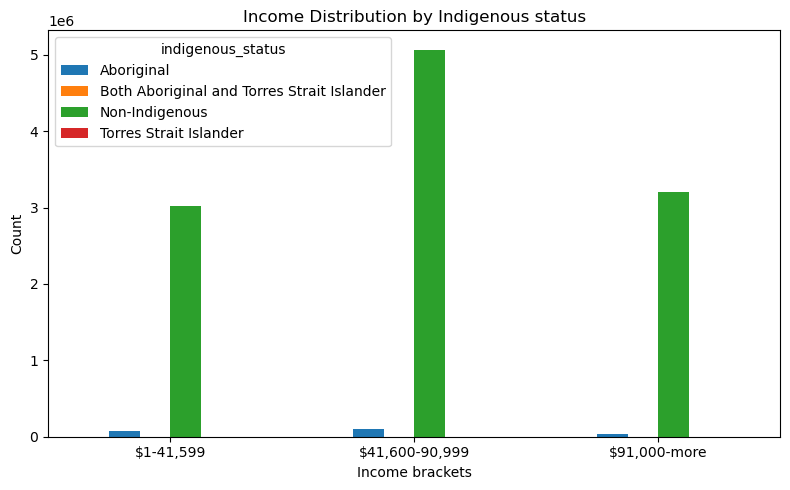

In [15]:
indigenous_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["indigenous_status"])

indigenous_income.plot(kind='bar', figsize=(8, 5))
plt.title("Income Distribution by Indigenous status")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar plot of income distribution by industry reveals a clear relationship between industry type and income level. Healthcare and Social Assistance workers make up the vast majority of income earners in the middle income bracket and the second largest category in the high income bracket. Retail trade and manufacturing make up the largest proportion of workers in the lower income bracket. In the higher income bracket, Professional, Scientific and Technical Services make up the largest category of earners with Public Administration and Safety workers making up the third largest group in the higher income bracket. Overall, there appears to be a trend between industry and income levels, with workers in certain industries such as healthcare and professional services earning higher incomes than workers in sectors such as manufacturing and retail trade.

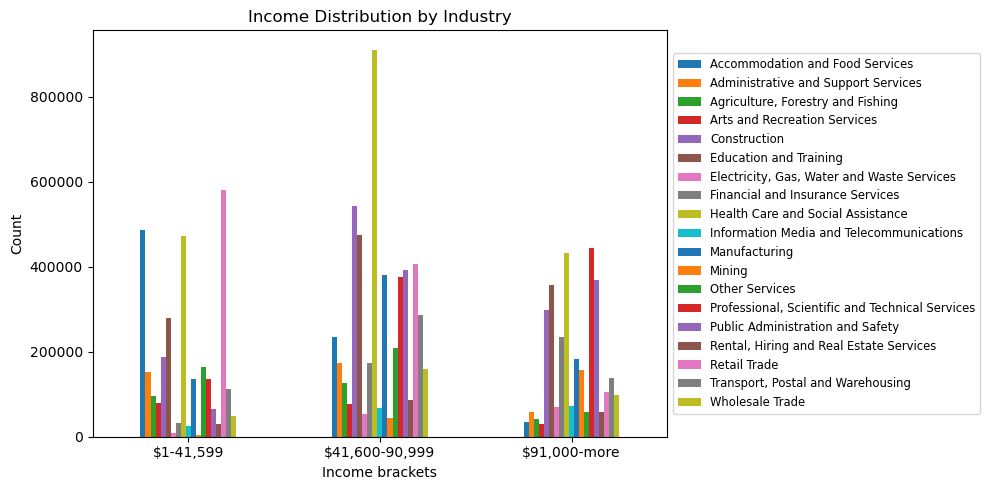

In [14]:
industry_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["industry"])

industry_income.plot(kind='bar', figsize=(10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', title_fontsize='medium')
plt.title("Income Distribution by Industry")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar plot of income distribution by health conditions illustrates that those with health conditions represent a small proportion of income earners in all income brackets when compared to those with no health conditions. This class imbalance is similar to what was observed with the `indigenous_status` variable which could reduce the influence of the health status in a predictive model. 

However, because individuals without health conditions do not appear to be overwhelmingly outnumbered, unlike the proportion of Indigenous to non-Indigenous workers, it may be appropriate to combine all health conditions into a single category. This would make the health_status variable a binary variable instead. Notably, this grouping can be done in a way that ensures individuals with health conditions still represent at least half of all income earners in each bracket.

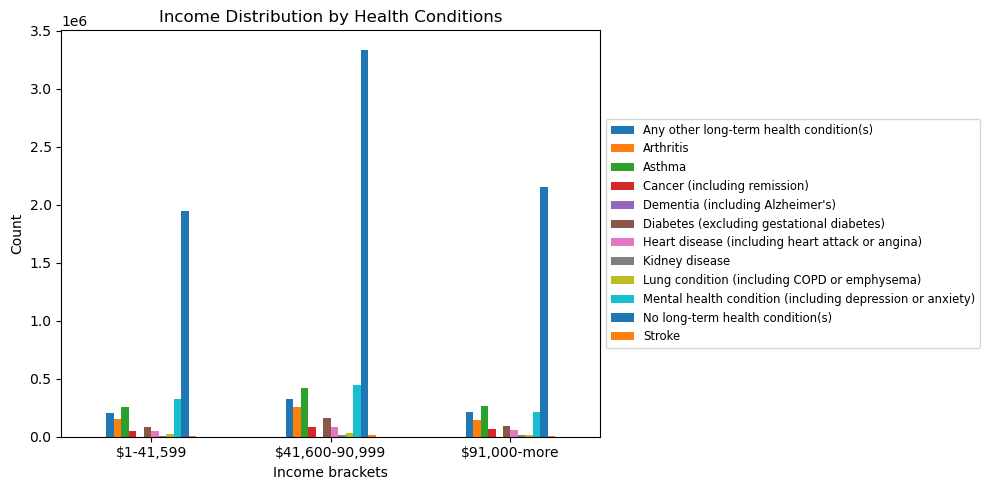

In [15]:
health_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["health_conditions"])

health_income.plot(kind='bar', figsize=(10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', title_fontsize='medium')
plt.title("Income Distribution by Health Conditions")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

After grouping all health conditions into a single category, the bar plot illustrates that those with health conditions make up a slightly larger share in the lower income bracket. However, in both the middle and higher income brackets, those with health conditions appear to make up at least half of all earners in each bracket. This suggests that the presence of a health condition does not strongly correlate with lower income levels in a linear way.

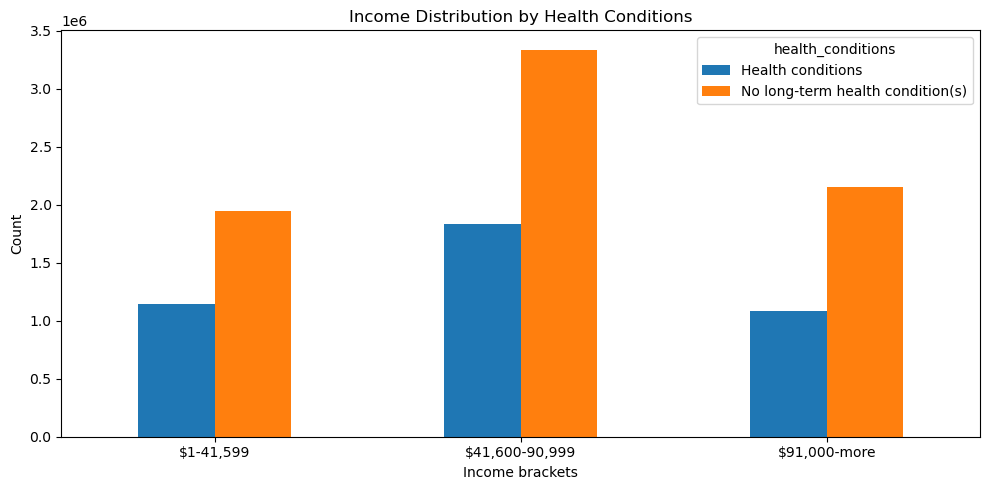

In [16]:
income_repeated.loc[income_repeated["health_conditions"] != "No long-term health condition(s)", "health_conditions"] = "Health conditions"
health_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["health_conditions"])

health_income.plot(kind='bar', figsize=(10, 5))
plt.title("Income Distribution by Health Conditions")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar plot of the income distribution by educational attainment reveals a clear relationship between educational attainment and income. In the lower income bracket, individuals whose highest education level was years 10 to 12 are overwhelmingly represented. In the middle income bracket, while this group still forms the largest proportion, there is a noticeable increase in individuals with diplomas, certificates, and bachelor degrees. Finally, in the higher income bracket, individuals with bachelor and postgraduate degrees made up the largest proportion of individuals.

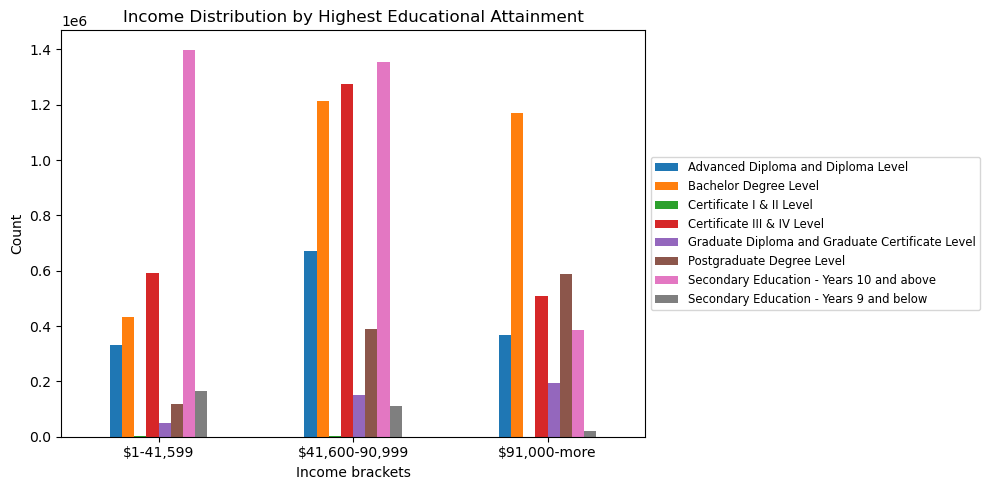

In [17]:
education_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["education"])

education_income.plot(kind='bar', figsize=(10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', title_fontsize='medium')
plt.title("Income Distribution by Highest Educational Attainment")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The bar plot of income distribution by age shows a clear trend: younger individuals tend to earn less, while income generally increases with age before tapering off. The lower income bracket is dominated by individuals aged 15–24. In the middle income bracket there is a significant increase in those who are in the 25-29 years to 60-65 years age groups. In the higher income bracket, those who are 30-34 years to 55-59 years represent the largest age groups, suggesting peak earning potential in those years.

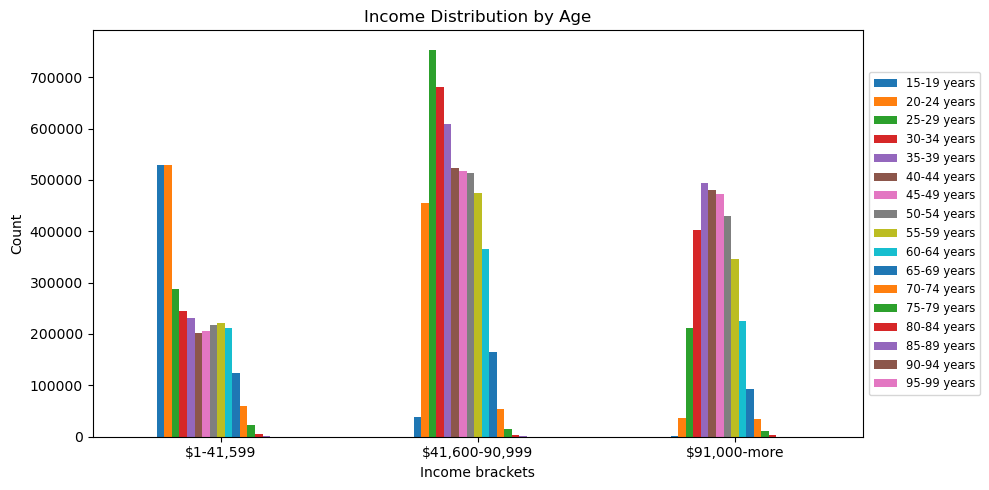

In [18]:
age_income = pd.crosstab(income_repeated["income_bracket"], income_repeated["age"])

age_income.plot(kind='bar', figsize=(10, 5))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize='small', title_fontsize='medium')
plt.title("Income Distribution by Age")
plt.xlabel("Income brackets")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

To assess the relationship between each variable and income levels, a Chi-squared test of independence was conducted. This test evaluates whether each variable is statistically independent of income level. For all variables, the resulting p-values were below 0.05, indicating significant associations. To quantify the strength of these associations, Cramer's V was calculated for each variable. This measure, which ranges from 0 (no association) to 1 (perfect association), provides insight into how strongly each variable is related to income.

In summary, all variables achieved a p-value of less than 0.05, suggesting that each variable is not independent of income earnings. Below is a summary of the results:

| Rank | Variable          | Cramer's V |
| ---- | ----------------- | ---------- |
| 1    | Age               | **0.3161** |
| 2    | Industry          | **0.3060** |
| 3    | Education         | **0.2700** |
| 4    | Sex               | **0.1991** |
| 5    | Indigenous Status | **0.0373** |
| 6    | Health Conditions | **0.0274** |

In [19]:
feature_variables = ["sex", "age", "education", "indigenous_status", "industry", "health_conditions"]

for variable in feature_variables:
    print(f"Variable: {variable}")

    contingency_table = pd.crosstab(income_repeated["income_bracket"], income_repeated[variable])

    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    print("Test statistic:", chi2)
    print("Degrees of freedom:", dof)
    print("p-value:", p)

    n = contingency_table.sum().sum()
    k = min(contingency_table.shape)

    cramers_v = np.sqrt(chi2 / (n * (k - 1)))

    print("Cramer's V:", cramers_v)

    print()

Variable: sex
Test statistic: 456144.2760887685
Degrees of freedom: 2
p-value: 0.0
Cramer's V: 0.19914634662174233

Variable: age
Test statistic: 2298500.09434439
Degrees of freedom: 32
p-value: 0.0
Cramer's V: 0.31610291004431346

Variable: education
Test statistic: 1677142.4677126105
Degrees of freedom: 14
p-value: 0.0
Cramer's V: 0.27001706296945877

Variable: indigenous_status
Test statistic: 16090.356298735567
Degrees of freedom: 6
p-value: 0.0
Cramer's V: 0.026447770127592293

Variable: industry
Test statistic: 2153248.2632224783
Degrees of freedom: 36
p-value: 0.0
Cramer's V: 0.3059519910539684

Variable: health_conditions
Test statistic: 8646.03821318327
Degrees of freedom: 2
p-value: 0.0
Cramer's V: 0.02741762323488517



The dataset currently contains more than 11.5 million rows. In order to create a machine learning model which can be trained in a reasonable amount of time, 200000 samples will be taken from the data.

In [26]:
income_truncated = income_repeated.sample(n=200000, random_state=44)

## Modeling

In preparing the data for the machine learning model, the variables Indigenous status and health conditions were excluded from the analysis. This decision was based on earlier tests, which showed a weak association between these variables and income levels, as indicated by low Cramer's V values.

The sex and industry variables, being nominal categorical features, were one-hot encoded. In contrast, age, education, and income levels are ordinal categorical variables, and were therefore encoded using a custom ordinal encoding scheme to preserve the inherent order within each feature.

Finally, the dataset was split into training and testing subsets to enable model evaluation on unseen data.

In [27]:
features = income_truncated.drop(["income_bracket", "indigenous_status", "health_conditions"], axis=1)
target = income_truncated["income_bracket"]

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), [
            "sex", 
            "industry"
        ])
    ],
    remainder='passthrough'
)

ordered_ages = [
    '15-19 years',
    '20-24 years',
    '25-29 years',
    '30-34 years',
    '35-39 years',
    '40-44 years',
    '45-49 years',
    '50-54 years',
    '55-59 years',
    '60-64 years',
    '65-69 years',
    '70-74 years',
    '75-79 years',
    '80-84 years',
    '85-89 years',
    '90-94 years',
    '95-99 years',
    '100 years and over'
]

ordered_education = [
    'Secondary Education - Years 9 and below',
    'Secondary Education - Years 10 and above',
    'Certificate I & II Level',
    'Certificate III & IV Level',
    'Advanced Diploma and Diploma Level',
    'Bachelor Degree Level',
    'Graduate Diploma and Graduate Certificate Level',
    'Postgraduate Degree Level'
]

ordered_classes = [
    "$1-41,599",
    "$41,600-90,999",
    "$91,000-more"
]

mapping_age = {label: idx for idx, label in enumerate(ordered_ages)}
mapping_edu = {label: idx for idx, label in enumerate(ordered_education)} 
mapping_income = {label: idx for idx, label in enumerate(ordered_classes)}

features["age"] = features["age"].map(mapping_age)
features["education"] = features["education"].map(mapping_edu)

features = column_transformer.fit_transform(features)

target = [mapping_income[label] for label in target]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=44)

Several models for prediction were evaluated including SVM, kNN, Random Forest and Decision tree models. The results are summarised as follows:

| **Model**         | **Accuracy** | **Precision (Class $1–41,599)** | **Precision (Class $41,600–90,999)** | **Precision (Class $91,000+)** |
| ----------------- | ------------ | -------------------------------------- | ------------------------------------------- | ------------------------------------- |
| **SVM**           | 0.58         | 0.61                                   | 0.54                                        | 0.68                                  |
| **200NN**         | 0.60         | 0.68                                   | 0.56                                        | 0.63                                  |
| **Random Forest** | 0.60         | 0.66                                   | 0.57                                        | 0.62                                  |
| **Decision Tree** | 0.60         | 0.66                                   | 0.57                                        | 0.63                                  |

In [22]:
X_train = X_train[:50000]
y_train = y_train[:50000]

model = SVC(kernel='poly')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.49      0.55     10626
           1       0.54      0.75      0.62     17927
           2       0.68      0.39      0.49     11447

    accuracy                           0.58     40000
   macro avg       0.61      0.54      0.56     40000
weighted avg       0.60      0.58      0.57     40000



In [28]:
model = KNeighborsClassifier(n_neighbors = 200)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.46      0.55     10691
           1       0.56      0.72      0.63     18065
           2       0.63      0.54      0.58     11244

    accuracy                           0.60     40000
   macro avg       0.62      0.57      0.59     40000
weighted avg       0.61      0.60      0.59     40000



In [29]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.48      0.55     10691
           1       0.57      0.70      0.63     18065
           2       0.62      0.55      0.59     11244

    accuracy                           0.60     40000
   macro avg       0.62      0.58      0.59     40000
weighted avg       0.61      0.60      0.60     40000



In [30]:
model = DecisionTreeClassifier(
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.48      0.56     10691
           1       0.57      0.70      0.63     18065
           2       0.63      0.54      0.58     11244

    accuracy                           0.60     40000
   macro avg       0.62      0.58      0.59     40000
weighted avg       0.61      0.60      0.60     40000



## Conclusion

Overall, all models demonstrated comparable performance in predicting income levels, with accuracies around 60%. The SVM model, while achieving similar accuracy to the others, was significantly slower to train on large datasets, requiring a reduced training set. Despite this limitation, its comparable results suggest that with more computational resources and time, SVM could potentially perform on par with or better than the other models.